# Student's t distribution

For more information, see chapters 9 and 12

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

Student's t distribution is defined as an ensamble of normal distributions "weighted" by precision terms $\tau$ that are Gamma-distributed. That is

$$
\begin{aligned}
    p(x|\mu, \alpha, \beta) &= \int_0^\infty \mathcal{N}\left(x |\mu, \tau^{-1}\right)\text{Gam}(\tau|\alpha, \beta) \ d\tau \\
    &= \frac{\beta^\alpha}{\Gamma(\alpha)}\left(\frac{1}{2\pi}\right)^{1/2}\left[b + \frac{(x - \mu)^2}{2}\right]^{-a - 1/2} \Gamma\left(a + \frac{1}{2}\right)
\end{aligned}
$$

Defining $\nu = 2\alpha$, $\lambda = \alpha/\beta$ and rearranging, we obtain the final form of the distribution in the form

$$
    \text{St}(x\vert\mu,\lambda,\nu) = \frac{\Gamma\big((\nu + 1)/2\big)}{\Gamma(\nu/2)}\left(\frac{\lambda}{\pi\nu}\right)^{1/2}\left[1 + \frac{\lambda(x - \mu)^2}{\nu}\right]^{-(\nu + 1)/2}
$$

* $\nu$ is known as the degrees of freedom of the distribution;
* $\lambda$ is known as the precision of the distribution

In [559]:
def students(x, mu, lmbda, nu):
    """
    Generates a function that returns the value
    of the pdf of a Student's-t distribution
    
    Parameters
    ----------
    x: float, np.array
        Values to evaluate the pdf at
    mu: float
        The mean of the distribution
    lmbda: float
        The precision of the distribution
    nu: float
        The degrees of freedom of the distributino
    """
    const = gamma(nu / 2 + 1 / 2) / gamma(nu / 2) * np.sqrt(lmbda / (np.pi * nu))
    pdf = const * (1 + (lmbda * (x - mu) ** 2) / nu) ** (-nu / 2 - 1 / 2)
    return pdf

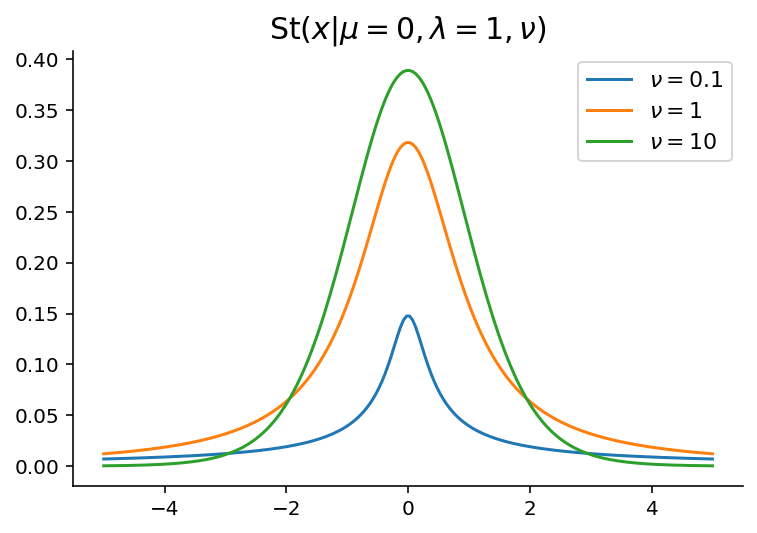

In [560]:
mu, lmbda= 0, 1

xrange = np.linspace(-5, 5, 200)

nus = [0.1, 1, 10]
for nu in nus:
    pdf = students(xrange, mu, lmbda, nu)
    plt.plot(xrange, pdf, label=rf"$\nu={nu}$");
plt.title(r"$\mathrm{St}"rf"(x\vert\mu={mu}, \lambda={lmbda}, \nu)$", fontsize=15)
plt.legend(fontsize=11);

## Estimating the value of a digamma

In [561]:
from scipy.special import digamma

In [562]:
def bisection(f, x_low, x_up, tol=1e-5, max_its=1000):
    diff = np.inf
    nits = 0
    while diff > tol:
        if nits >= max_its:
            raise ValueError("Root searching did not converge")
            
        x_mid = (x_low + x_up) / 2
        f_mid = f(x_mid)

        if np.sign(f_mid) == 1:
            x_up = x_mid
        else:
            x_low = x_mid

        diff = np.abs(f_mid)
        nits += 1
        
    return x_mid

def inverse_digamma(k, x_low=0.1, x_up=10, **kwargs):
    f = lambda x: digamma(x) - k
    return bisection(f, x_low, x_up, **kwargs)

In [563]:
k = digamma(5)
k

1.5061176684318003

In [564]:
inverse_digamma(k)

4.999998474121094

### Student's-t $a$ parameter estimation

To take an $M$-step in estimating the parameters of student's-t distribution, we require to satisfy the equality

$$
    \log a - \psi(a) = \frac{1}{N}\big(N \log\mathbb{E}[\tau] - \mathbb{E}[\log\tau]\big)
$$

More generally, we would like to find $a \in\mathbb{R}$ that satisfies

$$
   \big(\log a - \psi(a)\big) - b = 0
$$

for any given $b\in\mathbb{R}$

In [566]:
import os
import requests
import pandas as pd
import seaborn as sns
from scipy.stats import norm

In [567]:
apikey = os.environ["AVANTAGE_API"]

In [568]:
# https://www.alphavantage.co/documentation/
url = "https://www.alphavantage.co/query"
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "TSLA",
    "outputsize": "full",
    "apikey": apikey
}

In [19]:
r = requests.get(url, params=params)

In [569]:
tsla = pd.DataFrame.from_dict(r.json()["Time Series (Daily)"], orient="index", dtype=float)
tsla.index = pd.to_datetime(tsla.index)
tsla = tsla.sort_index()

In [570]:
tsla_ret = tsla["5. adjusted close"].pct_change().dropna()
N = len(tsla_ret)
mu, sigma = tsla_ret.mean(), tsla_ret.std(ddof=1)
N_tsla = norm(loc=mu, scale=sigma)

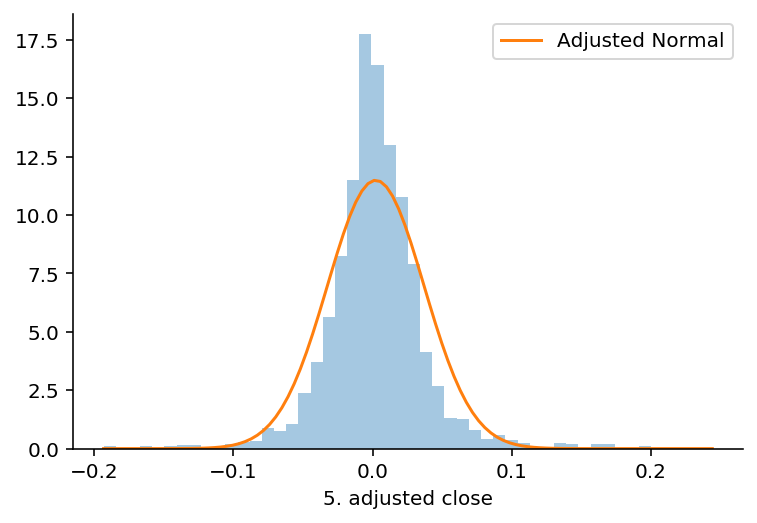

In [571]:
xrange = np.linspace(tsla_ret.min(), tsla_ret.max(), 100)
sns.distplot(tsla["5. adjusted close"].pct_change(), kde=False, norm_hist=True);
plt.plot(xrange, N_tsla.pdf(xrange), label="Adjusted Normal")
plt.legend();

In [596]:
class T_dist:
    def __init__(self, X):
        self.X = X
        self.N = len(X)
        self.mu = X.mean()

In [1442]:
def E_tau(a, b, mu, X):
    return (a + 1 / 2) / (b + (X - mu) ** 2)

def E_log_tau(a, b, mu, X):
    return digamma(a + 1 / 2) - np.log(b + (X - mu) ** 2)

In [1446]:
a = 1
b = 1
mu = 1

E = E_tau(a, b, mu, tsla_ret)
E_log = E_log_tau(a, b, mu, tsla_ret)

In [1503]:
print(a, b)
mu = (E * tsla_ret).sum() / E.sum()
a, b = inverse_digamma((E_log.sum() + N * np.log(b)) / N), (a * N) / E.sum()

2.442292022705078 1.8063775072250279


In [1491]:
E = E_tau(a, b, mu, tsla_ret)
E_log = E_log_tau(a, b, mu, tsla_ret)

In [550]:
2 * a

0.26033511161804196

In [558]:
np.sqrt(b / a)

0.04911452854891513

In [557]:
tsla_ret.mean()

0.0022102666964439973

In [159]:
eta = 2 * a_new # degrees of freedom
lmbda = a_new / b_new # precision
mu_t = tsla_ret.mean() # mean

In [160]:
from scipy.stats import t

In [182]:
T_tsla = t(df=eta, loc=mu_t, scale=1/lmbda)

In [187]:
t.fit(tsla_ret)

(2.948196537687446, 0.0014012266517985468, 0.021381725626135252)